In [22]:
import subprocess
import re
import sys
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")

In [23]:
_DUR_RE = re.compile(r"(?P<val>[\d.]+)\s*(?P<unit>ns|µs|us|ms|s|m|h)")
_UNIT_TO_MS = {"ns": 1e-6, "µs": 1e-3, "us": 1e-3, "ms": 1, "s": 1000, "m": 60000, "h": 3600000}

def duration_to_ms(text: str) -> float:
    total_ms = 0.0
    for m in _DUR_RE.finditer(text):
        total_ms += float(m.group("val")) * _UNIT_TO_MS[m.group("unit")]
    return total_ms

In [24]:
SEQ_RE   = re.compile(r"^\s*(Cosine|Pearson|Jaccard)\s+Seq\s+([-\d.]+)", re.I)
CON_RE   = re.compile(r"^\s*(Cosine|Pearson|Jaccard)\s+Con\s+([-\d.]+)", re.I)
TIME_RE  = re.compile(r"^\s*Time duration\s+(.+?)\s*$", re.I)

def run_algo(go_file: Path, alg: str, dim: int, goroutines: int, seed: int):
    cmd = [
        "go", "run", str(go_file),
        f"-goroutines={goroutines}",
        f"-seed={seed}",
        f"-dim={dim}",
        f"-algorithm={alg}",
    ]
    res = subprocess.run(cmd, capture_output=True, text=True, check=True)
    stdout = res.stdout.splitlines()

    seq_val, seq_time, con_val, con_time = None, None, None, None
    last_mode = None

    for line in stdout:
        if (m := SEQ_RE.match(line)):
            seq_val, last_mode = float(m.group(2)), "seq"
        elif (m := CON_RE.match(line)):
            con_val, last_mode = float(m.group(2)), "con"
        elif (m := TIME_RE.match(line)):
            ms = duration_to_ms(m.group(1))
            if last_mode == "seq": seq_time = ms
            elif last_mode == "con": con_time = ms
            last_mode = None

    records = []
    if seq_val is not None:
        records.append({"algorithm": alg, "mode": "sequential", "value": seq_val, "duration_ms": seq_time})
    if con_val is not None:
        records.append({"algorithm": alg, "mode": "concurrent", "value": con_val, "duration_ms": con_time})

    return records, "\n".join(stdout)

In [ ]:
def benchmark(go_file, algs, dims, goroutines_list, seed, repeats=20):
    records = []

    for dim in dims:
        for goroutines in goroutines_list:
            for alg in algs:
                for r in range(repeats):
                    recs, _ = run_algo(go_file, alg, dim=dim, goroutines=goroutines, seed=seed + r)
                    for rec in recs:
                        rec["run"] = r
                        rec["dim"] = dim
                        rec["goroutines"] = goroutines
                        records.append(rec)
    return pd.DataFrame(records)

# Example usage:
df = benchmark(
    go_file=Path("/home/giorgio6846/Code/Clases/Programacion-CyD/PC2/PC2/pc2_alt2.go"),
    algs=["cosine", "pearson", "jaccard"],
    dims=[1000000, 3000000, 5000000, 7000000],
    goroutines_list=[20, 40, 60, 80, 100, 120, 140, 160],
    seed=42,
    repeats=20
)

In [27]:
summary = df.groupby(["algorithm", "mode", "dim", "goroutines"]).agg(
    mean_time=("duration_ms", "mean"),
    std_time=("duration_ms", "std"),
    mean_value=("value", "mean"),
).reset_index()

summary

,algorithm,mode,dim,goroutines,mean_time,std_time,mean_value
0,cosine,concurrent,1000000,20,0.441704,0.037639,0.749984
1,cosine,concurrent,1000000,40,0.433070,0.041489,0.749984
2,cosine,concurrent,1000000,60,0.450850,0.046542,0.749984
3,cosine,concurrent,1000000,80,0.459283,0.049799,0.749984
4,cosine,concurrent,1000000,100,0.479981,0.057478,0.749984
...,...,...,...,...,...,...,...
235,pearson,sequential,5000000,80,10.621058,0.047632,0.000053
236,pearson,sequential,5000000,100,10.628087,0.104666,0.000053
237,pearson,sequential,5000000,120,10.632708,0.063822,0.000053
238,pearson,sequential,5000000,140,10.634475,0.063800,0.000053


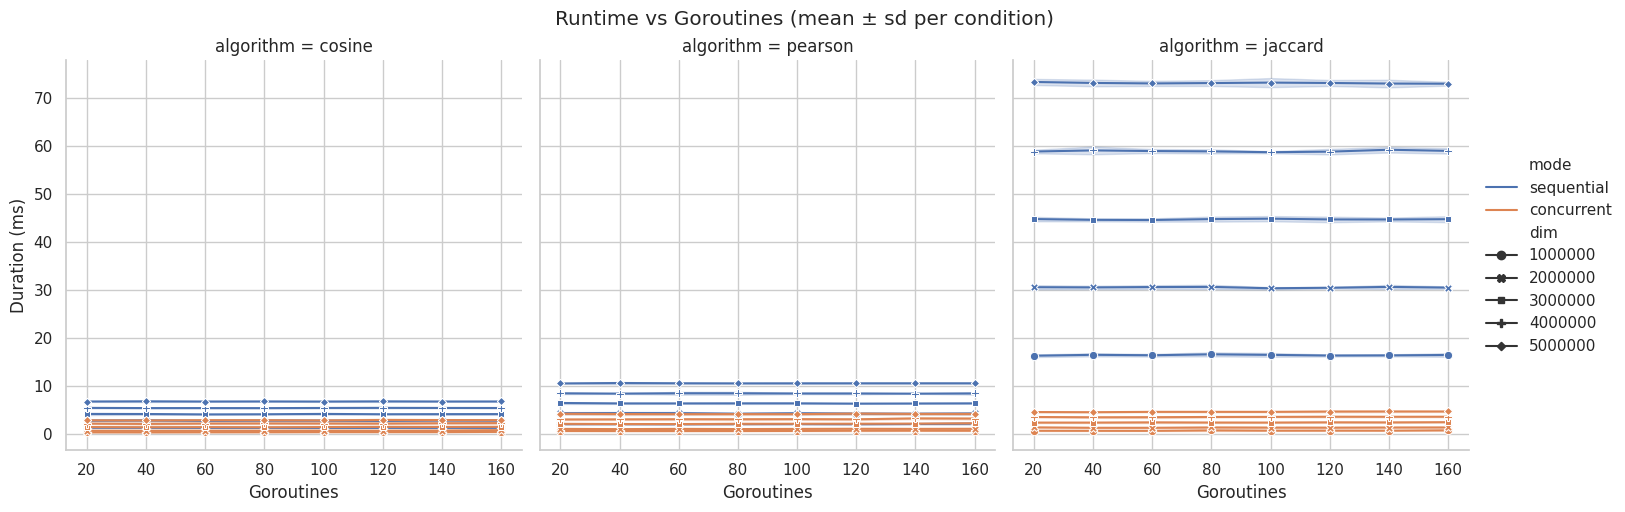

In [32]:
g = sns.relplot(
    data=df,
    kind="line",
    x="goroutines", y="duration_ms",
    hue="mode", style="dim",
    col="algorithm", col_wrap=3,
    markers=True, dashes=False,
    errorbar=("sd")  # show variability from your repeats
)
g.set_axis_labels("Goroutines", "Duration (ms)")
g.fig.suptitle("Runtime vs Goroutines (mean ± sd per condition)", y=1.02)
plt.show()

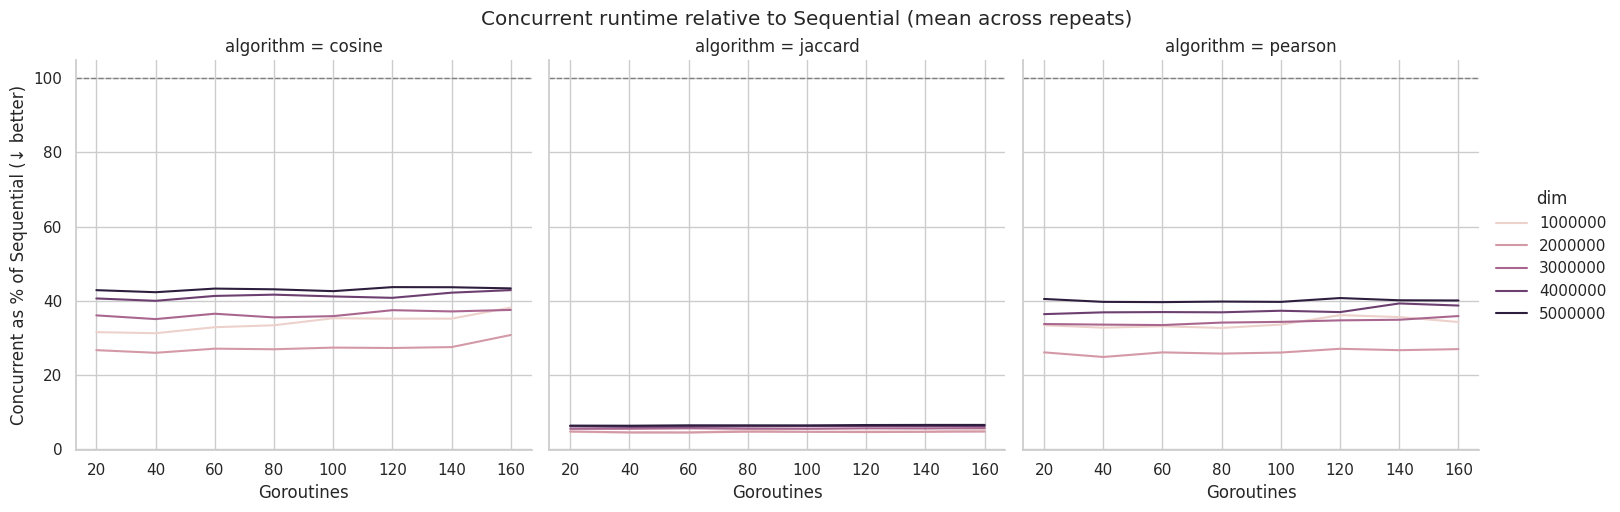

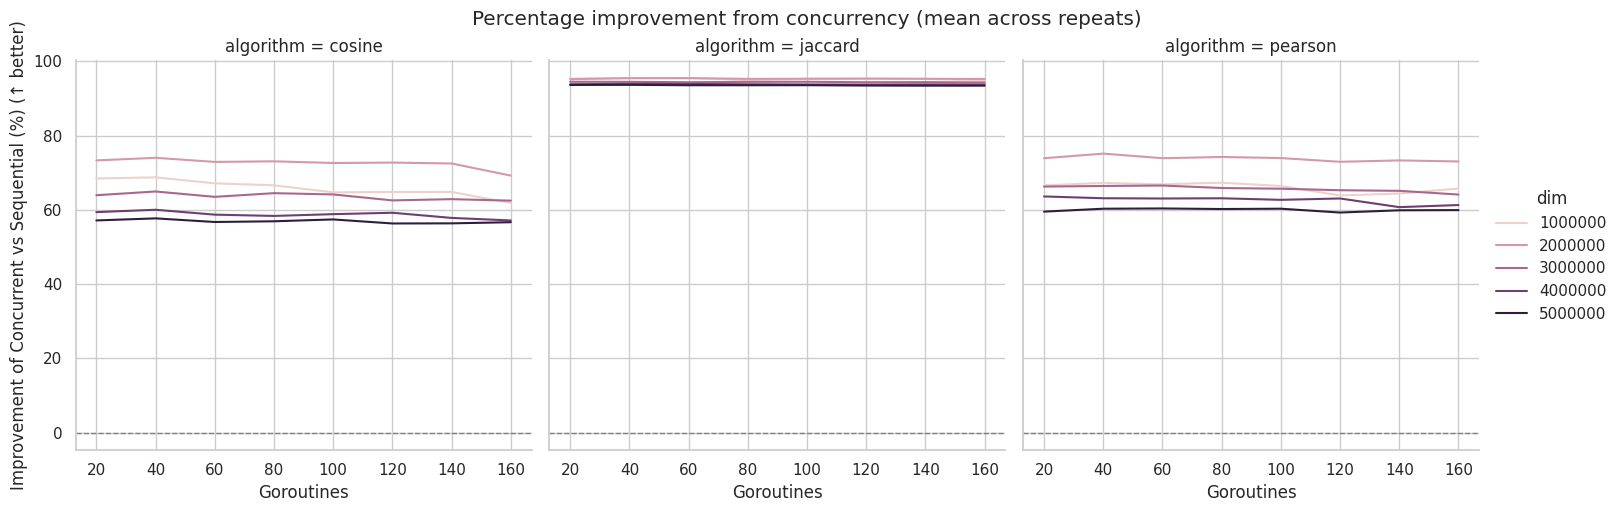

In [31]:
# Build per-run pivot to pair seq/con, then average to be robust
per_run = df.pivot_table(
    index=["algorithm","dim","goroutines","run"],
    columns="mode",
    values="duration_ms",
    aggfunc="first"
).reset_index()

# Compute ratios per run
per_run["ratio_con_over_seq"] = per_run["concurrent"] / per_run["sequential"]
per_run["pct_con_of_seq"]     = 100 * per_run["ratio_con_over_seq"]
per_run["pct_improve"]        = 100 * (1 - per_run["ratio_con_over_seq"])

# Average across repeats for plotting
pct_summary = per_run.groupby(["algorithm","dim","goroutines"], as_index=False).agg(
    mean_pct_con_of_seq=("pct_con_of_seq","mean"),
    sd_pct_con_of_seq=("pct_con_of_seq","std"),
    mean_pct_improve=("pct_improve","mean"),
    sd_pct_improve=("pct_improve","std"),
)

# A) Concurrent as % of sequential (target < 100%)
g1 = sns.relplot(
    data=pct_summary, kind="line",
    x="goroutines", y="mean_pct_con_of_seq",
    hue="dim", col="algorithm", col_wrap=3,
    markers=True, dashes=False,
    errorbar=None
)
for ax, (alg) in zip(g1.axes.flatten(), pct_summary["algorithm"].unique()):
    ax.axhline(100, ls="--", lw=1, color="gray")  # baseline: equal speed
g1.set_axis_labels("Goroutines", "Concurrent as % of Sequential (↓ better)")
g1.fig.suptitle("Concurrent runtime relative to Sequential (mean across repeats)", y=1.02)
plt.show()

# B) % improvement (target > 0%)
g2 = sns.relplot(
    data=pct_summary, kind="line",
    x="goroutines", y="mean_pct_improve",
    hue="dim", col="algorithm", col_wrap=3,
    markers=True, dashes=False,
    errorbar=None
)
for ax in g2.axes.flatten():
    ax.axhline(0, ls="--", lw=1, color="gray")  # baseline: no improvement
g2.set_axis_labels("Goroutines", "Improvement of Concurrent vs Sequential (%) (↑ better)")
g2.fig.suptitle("Percentage improvement from concurrency (mean across repeats)", y=1.02)
plt.show()
